# FGSM Attack and Binary Input Detector Using CIFAR10

This notebook shows the Fast Gradient Method attack implmentation using the ART library against deep learning models trained on CIFAR-10 dataset. The notebook covers the following:

* Load the required libariries
* Load the dataset and inspect the data
* Create a deep learning model
* Train and evaluate the deep learning model on CIFAR test data
* Create an ART Keras classifier.
* Implement FGSM attack using ART
* Create adversarial samples using the FGSM attack
* Evaluate the deep leaarning model against the adversaarial samples
* Create a detector model to detect adversarial samples
* Train and evaluate the detector model

### 0. Install and import required libraries

In [2]:
# Install prerequired libraries.
# !pip install adversarial-robustness-toolbox

In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from art.utils import load_cifar10, preprocess, to_categorical

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.detector.evasion import BinaryInputDetector

### 1. Load the CIFAR10 data set and class descriptions:

In [4]:
# (x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
# Load the dataset from the local drive
data = np.load('./../datasets/cifar10_dataset.npz')
x_train, y_train, x_test, y_test= data['X_train'], data['y_train'], data['X_test'], data['y_test']

class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

min = x_train.min()
max = x_train.max()

x_train.shape, y_train.shape, x_test.shape, y_test.shape, min, max

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10), 0.0, 1.0)

<a id="classifier"></a>
### 2. Evaluating the classifier

Create a model using Keras API. Here we use the Keras Sequential model (a ResNet architecture) and add a sequence of layers. Afterwards the model is compiles with optimizer, loss function and metrics.

In [6]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)
    
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X
    
b2 = ResnetBlock(64, 2, first_block=True,)
b3 = ResnetBlock(128, 2)
b4 = ResnetBlock(256, 2)
b5 = ResnetBlock(512, 2)

def net():
    model = tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', input_shape=(32,32,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        b2,
        b3,
        b4,
        b5,
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=10, activation='softmax')])

    loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    optimizer=tf.optimizers.legacy.Adam(learning_rate=0.0001)

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return model

Instructions for updating:
Colocations handled automatically by placer.


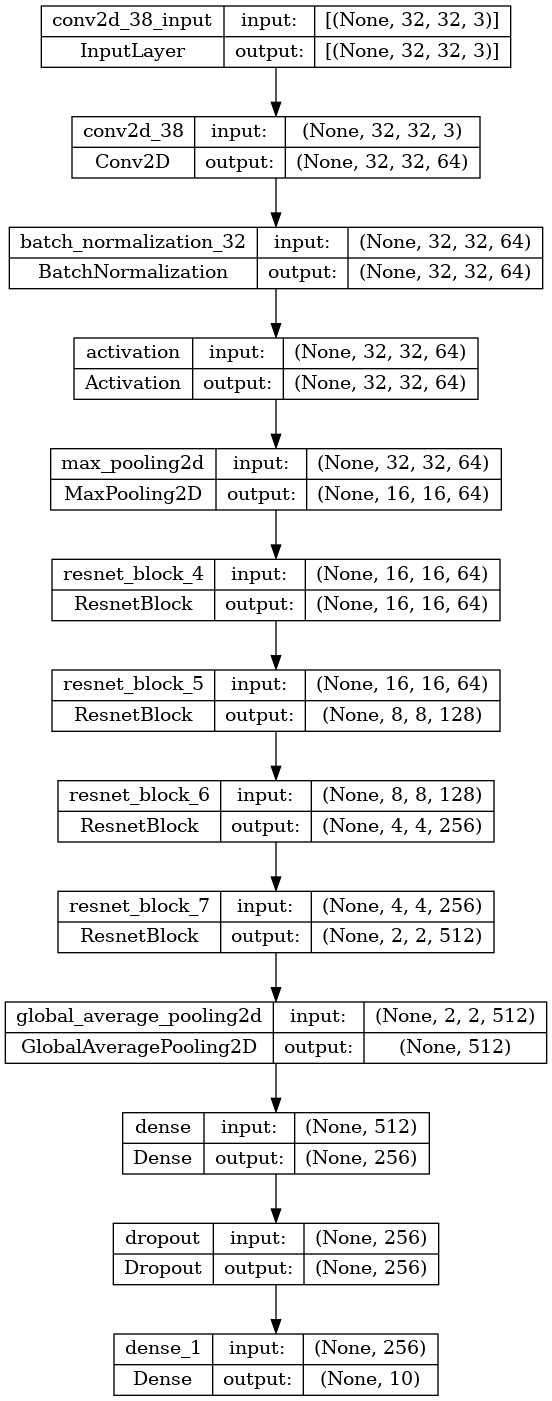

In [7]:
model = net()
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
# history = model.fit(x_train, y_train, batch_size=32, epochs = 25)

Train on 50000 samples
Epoch 1/25
50000/50000 [==============================] - 48s 962us/sample - loss: 1.2802 - accuracy: 0.5430
Epoch 2/25
50000/50000 [==============================] - 48s 957us/sample - loss: 0.9444 - accuracy: 0.6729
Epoch 3/25
50000/50000 [==============================] - 48s 954us/sample - loss: 0.7424 - accuracy: 0.7407
Epoch 4/25
50000/50000 [==============================] - 48s 951us/sample - loss: 0.5762 - accuracy: 0.8019
Epoch 5/25
50000/50000 [==============================] - 48s 962us/sample - loss: 0.4374 - accuracy: 0.8496
Epoch 6/25
50000/50000 [==============================] - 48s 964us/sample - loss: 0.3264 - accuracy: 0.8875
Epoch 7/25
50000/50000 [==============================] - 48s 960us/sample - loss: 0.2484 - accuracy: 0.9149
Epoch 8/25
50000/50000 [==============================] - 48s 963us/sample - loss: 0.1946 - accuracy: 0.9335
Epoch 9/25
50000/50000 [==============================] - 48s 962us/sample - loss: 0.1647 - accuracy: 0.9

In [8]:
# Save/Load the model 
# model.save('./../models/cifar10_resnet18.tf')
model = tf.keras.models.load_model('./../models/cifar10_resnet18.tf')
model.summary()

2024-05-15 15:59:13.026024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 15:59:13.238098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1368 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-05-15 15:59:13.238870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43999 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5
2024-05-15 15:59:14.141223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localh

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  (None, 16, 16, 64)        148736    
                                                                 
 resnet_block_1 (ResnetBlock  (None, 8, 8, 128)        5

Evaluate model accuracy on test data.

In [9]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2024-05-15 15:59:20.923147: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:3787 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-15 15:59:21.825317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902


Accuracy on test data: 72.81%


In [10]:
classifier = KerasClassifier(model=model, clip_values=(min, max))

## Fast Gradient Method (FGM)
> class art.attacks.evasion.FastGradientMethod(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, minimal: bool = False, summary_writer: str | bool | SummaryWriter = False)

This attack was originally implemented by Goodfellow et al. (2015) with the infinity norm (and is known as the “Fast Gradient Sign Method”). This implementation extends the attack to other norms, and is therefore called the Fast Gradient Method.
* Paper link: https://arxiv.org/abs/1412.6572

*\_\_init__(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, minimal: bool = False, summary_writer: str | bool | SummaryWriter = False) → None*

**Create a FastGradientMethod instance.**

     Parameters:
* estimator – A trained classifier.
* norm – The norm of the adversarial perturbation. Possible values: “inf”, np.inf, 1 or 2.
* eps – Attack step size (input variation).
* eps_step – Step size of input variation for minimal perturbation computation.
* targeted (bool) – Indicates whether the attack is targeted (True) or untargeted (False)
* num_random_init (int) – Number of random initialisations within the epsilon ball. For random_init=0 starting at the original input.
* batch_size (int) – Size of the batch on which adversarial samples are generated.
* minimal (bool) – Indicates if computing the minimal perturbation (True). If True, also define eps_step for the step size and eps for the maximum perturbation.
* summary_writer – Activate summary writer for TensorBoard. Default is False and deactivated summary writer. If True save runs/CURRENT_DATETIME_HOSTNAME in current directory. If of type str save in path. If of type SummaryWriter apply provided custom summary writer. Use hierarchical folder structure to compare between runs easily. e.g. pass in ‘runs/exp1’, ‘runs/exp2’, etc. for each new experiment to compare across them.

    
**generate(x: ndarray, y: ndarray | None = None, \*\*kwargs) → ndarray**

Generate adversarial samples and return them in an array.

    Return type:
* ndarray
    
    
    Parameters:
* x (ndarray) – An array with the original inputs.
* y – Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape (nb_samples,). Only provide this parameter if you’d like to use true labels when crafting adversarial samples. Otherwise, model predictions are used as labels to avoid the “label leaking” effect (explained in this paper: https://arxiv.org/abs/1611.01236). Default is None.

* mask (np.ndarray) – An array with a mask broadcastable to input x defining where to apply adversarial perturbations. Shape needs to be broadcastable to the shape of x and can also be of the same shape as x. Any features for which the mask is zero will not be adversarially perturbed.

        Returns:
* An array holding the adversarial examples.

Link: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm


### Create an ART Fast Gradient Sign Method attack.

In [19]:
# eps – defines the attack step size (input variation). The smaller the eps, the little the attack scale would be.
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2)

### Generate adversarial test data.

In [ ]:
x_test_adv = attack_fgsm.generate(x_test)

### Evaluate the classifier on the first 100 test images:

In [ ]:
x_test_pred = np.argmax(classifier.predict(x_test[:100]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(100-nb_correct_pred))

For illustration purposes, look at the first 9 images. (In brackets: true labels.)

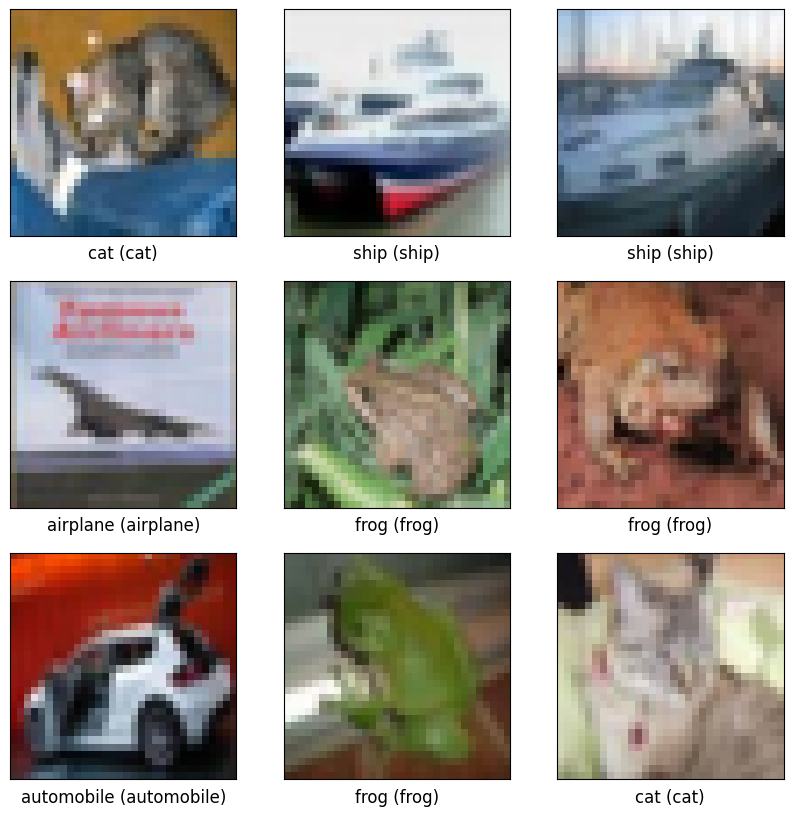

In [8]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes,
                  horizontalalignment='center')

Generate some adversarial samples:

In [9]:
attacker = FastGradientMethod(classifier, eps=0.05)
x_test_adv = attacker.generate(x_test[:100]) # this takes about two minutes

Evaluate the classifier on 100 adversarial samples:

In [10]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_pred))

Adversarial test data (first 100 images):
Correctly classified: 20
Incorrectly classified: 80


Now plot the adversarial images and their predicted labels (in brackets: true labels).

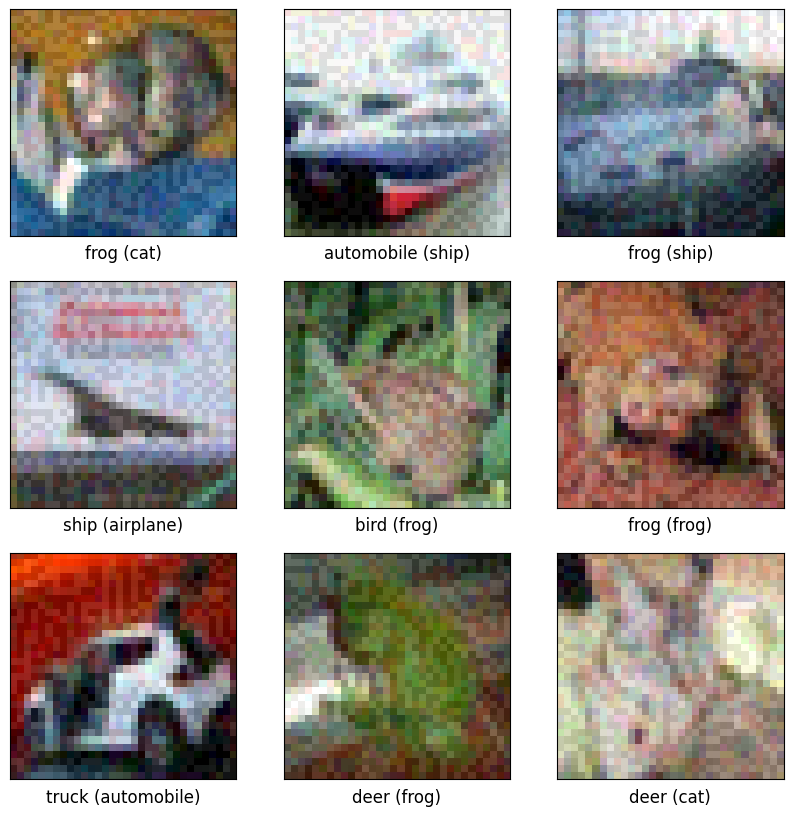

In [11]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_adv_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test_adv[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes,
                  horizontalalignment='center')

<a id="train_detector"></a>
## 3. Training the detector

Load the detector model (which also uses a ResNet architecture):

In [12]:
path = get_file('BID_eps=0.05.h5',extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/cbyfk65497wwbtn/BID_eps%3D0.05.h5?dl=1')
detector_model = load_model(path)
detector_classifier = KerasClassifier(clip_values=(-0.5, 0.5), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [ ]:
detector_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 32, 32, 16)   0           ['batch_normalization_1[0][

To train the detector:
- we expand our training set with adversarial samples
- we label the data with 0 (original) and 1 (adversarial)

In [13]:
x_train_adv = attacker.generate(x_train)
nb_train = x_train.shape[0]

x_train_detector = np.concatenate((x_train, x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

In [14]:
x_train_detector.shape, y_train_detector.shape

((200, 32, 32, 3), (200, 2))

Perform the training:

In [19]:
detector.fit(x_train_detector, y_train_detector, nb_epochs=5, batch_size=20)

Train on 200 samples
Epoch 1/5
200/200 [==============================] - 4s 20ms/sample - loss: 0.0136 - accuracy: 1.0000
Epoch 2/5
200/200 [==============================] - 4s 19ms/sample - loss: 0.0053 - accuracy: 1.0000
Epoch 3/5
200/200 [==============================] - 7s 37ms/sample - loss: 0.0070 - accuracy: 1.0000
Epoch 4/5
200/200 [==============================] - 4s 22ms/sample - loss: 0.0051 - accuracy: 1.0000
Epoch 5/5
200/200 [==============================] - 4s 19ms/sample - loss: 0.0049 - accuracy: 1.0000


<a id="detector"></a>
## 4. Evaluating the detector

Apply the detector to the adversarial test data:

In [17]:
_, is_adversarial = detector.detect(x_test_adv)
flag_adv = np.sum(is_adversarial)

print("Adversarial test data (first 100 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(100 - flag_adv))

Adversarial test data (first 100 images):
Flagged: 100
Not flagged: 0


Apply the detector to the first 100 original test images:

In [20]:
_, is_adversarial = detector.detect(x_test[:100])
flag_original = np.sum(is_adversarial)

print("Original test data (first 100 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(100 - flag_original))

Original test data (first 100 images):
Flagged: 100
Not flagged: 0


Evaluate the detector for different attack strengths `eps`
(**Note**: for the training of detector, `eps=0.05` was used)

In [21]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_flag_adv = []
nb_missclass = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(x_test[:100])
    nb_flag_adv += [np.sum(detector.detect(x_test_adv)[1])]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))]

eps_range = [0] + eps_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [2] + nb_missclass

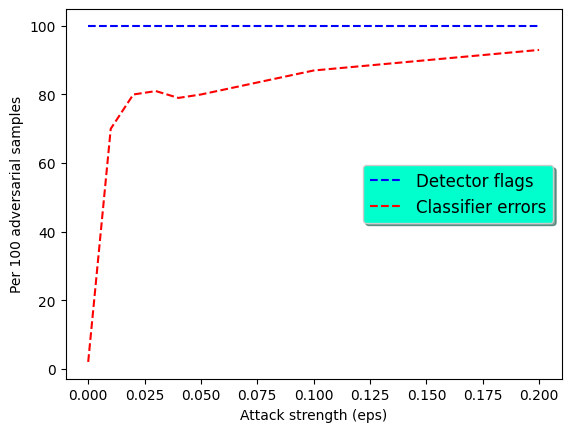

In [22]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range)[:8], np.array(nb_flag_adv)[:8], 'b--', label='Detector flags')
ax.plot(np.array(eps_range)[:8], np.array(nb_missclass)[:8], 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Per 100 adversarial samples')
plt.show()